# Reddit NLP and Text Modeling

# Table of contents:

<ul>
<li><a href="#intro">i) Introduction</a></li>
<li><a href="#import">ii) Import Dependencies</a></li>    
<li><a href="#scraping">iii) Web Scraping (Data Collection)</a></li>
<li><a href="#text_to_features">iv) Preprocessing (Set up X, y and Tokenization)</a></li>
<li><a href="#pipeline">v) Pipelines for Modelling</a></li>
<li><a href="#evaluate">vi) Model Selection & Evaluation</a></li>    
<li><a href="#conclusions">vii) Conclusions</a></li>
</ul>

<a id='intro'></a>
# i) Introduction

Selected subb-Reddits I have chosen are centered on personal interests in how people try understand and answer life's toughest questions. These can be found in the links below:

* [r/AskScience](https://www.reddit.com/r/askscience/)  
* [r/AskPhilosophy](https://www.reddit.com/r/askphilosophy/)

I have scraped the data as can be seen in section iii *(in another notebook)*. The aim of this project would be to see which words are being used often in the *'r/AskScience'* or *'r/AskPhilosophy'* context.

<a id='import'></a>
# ii) Import Dependencies

In [1]:
# Preprocessing
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup  
from wordcloud import WordCloud

# Word Normalization
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Model Evaluation
from sklearn.metrics import confusion_matrix

%matplotlib inline

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)

<a id='scraping'></a>
# iii) Web Scraping (Data Collection)

Refer to `02_reddit-nlp-and-text-modeling.ipynb`

<a id="text_to_features"></a> 
# iv) Preprocessing

- Load datasets
- Remove HTML code artifacts, and stop words in `selftext` column
- Tokenization, Lemmatization words in `selftext` column
- Set up X and y (model prep)
- Split our data into training and testing sets

In [2]:
# Load datasets
askscience = pd.read_csv('askscience.csv')
askphilosophy = pd.read_csv('askphilosophy.csv')

In [3]:
# Create copies of datasets
sci_df = askscience.copy()
philo_df = askphilosophy.copy()

In [4]:
# Filter for features needed
sci_df = sci_df[['selftext', 'subreddit']][1:].reset_index(drop=True)
philo_df = philo_df[['selftext', 'subreddit']][1:].reset_index(drop=True)

# Check dimensionality
sci_df.shape, philo_df.shape

((1127, 2), (1104, 2))

In [5]:
# Check for null values
sci_df.isnull().sum().sum(), philo_df.isnull().sum().sum()

(352, 128)

In [6]:
# Drop rows with null values
sci_df.dropna(inplace=True)
philo_df.dropna(inplace=True)

In [7]:
# Check
sci_df.shape, philo_df.shape

((775, 2), (976, 2))

In [8]:
# Concat askscience and askphilosopy DataFrames
df = pd.concat([sci_df, philo_df])

# Reset index
df.reset_index(drop=True, inplace=True)

In [9]:
# Check if indexing is correct
df.tail()

,selftext,subreddit
1746,Ok so I’m in the process of reading Groundwork...,askphilosophy
1747,"After reading Victor Frankl's ""Man's Search Fo...",askphilosophy
1748,Plato's Republic Book I has a debate between S...,askphilosophy
1749,Dear Ann: Recently I was shopping downtown in...,askphilosophy
1750,I am studying art theory and reading Heidegger...,askphilosophy


In [10]:
# Create another column for cleaned selftext
df['selftext_cleaned'] = ''

### Remove HTML code artificats, punctuations and stop words

In [11]:
# Function to convert a subreddit to a string of words
def only_words(reddit_text):
    # 1. Remove HTML
    review_text = BeautifulSoup(reddit_text).get_text()
    
    # 2a. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 2b. Remove websites
    letters_only = re.sub("\(.*\)", " ", review_text)
    
    # 2c. Remove images
    letters_only = re.sub("\[.*\]", " ", letters_only) 
    
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 4. Convert the stop words to a set
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words
    meaningful_words = [w for w in words if w not in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [12]:
# apply function to df to clean 'selftext' column
for i in range(df.shape[0]):
    df.selftext_cleaned[i] = only_words(df.selftext[i])

/Users/jeromechua/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "https://www.irishcentral.com/news/community/hogan-twins-share-brain" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


### Tokenize &  Lemmatize `selftext` column

In [13]:
# Instantiate tokenizer
tokenizer = RegexpTokenizer(r'\w+')
tokenized = df['selftext_cleaned'].apply(tokenizer.tokenize)

# Instatntiate lemmatizer
lemmatizer = WordNetLemmatizer()
lemmatized_list = []
for i,v in enumerate(tokenized):
     l1 = tokenized[i]
     l2 = ' '.join([lemmatizer.lemmatize(word) for word in l1])
     lemmatized_list.append(l2)

##### Engineer a feature to turn `subreddit` into a 1/0 column, where 1 indicates the `askscience` thread

In [14]:
# Create a binary column for prediction value
df['askscience'] = [1 if df.loc[i,'subreddit'] == 'askscience' else 0 for i in range(df.shape[0])]

In [15]:
# rearrange columns in df
df = df[['selftext', 'selftext_cleaned', 'subreddit', 'askscience']]
df.head()

,selftext,selftext_cleaned,subreddit,askscience
0,Today is International Restart-a-Heart Day (ht...,today international restart-a-heart day signif...,askscience,1
1,Measles is one of the most contagious diseases...,measles one contagious diseases known doctors....,askscience,1
2,"I am taking AP Chemistry this year, and we're ...","taking ap chemistry year, we're currently stud...",askscience,1
3,I was watching a lecture about assemblers/comp...,watching lecture assemblers/compilers lecturer...,askscience,1
4,Years ago I actually had several courses on GR...,years ago actually several courses gr qft elec...,askscience,1


After cleaning the `selftext` column, and after applying word normalisation to it.
I have set up a feature, `askscience`, where it will be used to predict discrete class labels: `1` for *'askscience' *& `0` for *'askphilosophy'*.

##### Generate Word Cloud for both threads

In [16]:
phi_wordcloud = df[df['subreddit'] == 'askphilosophy']
sci_wordcloud = df[df['subreddit'] == 'askscience']

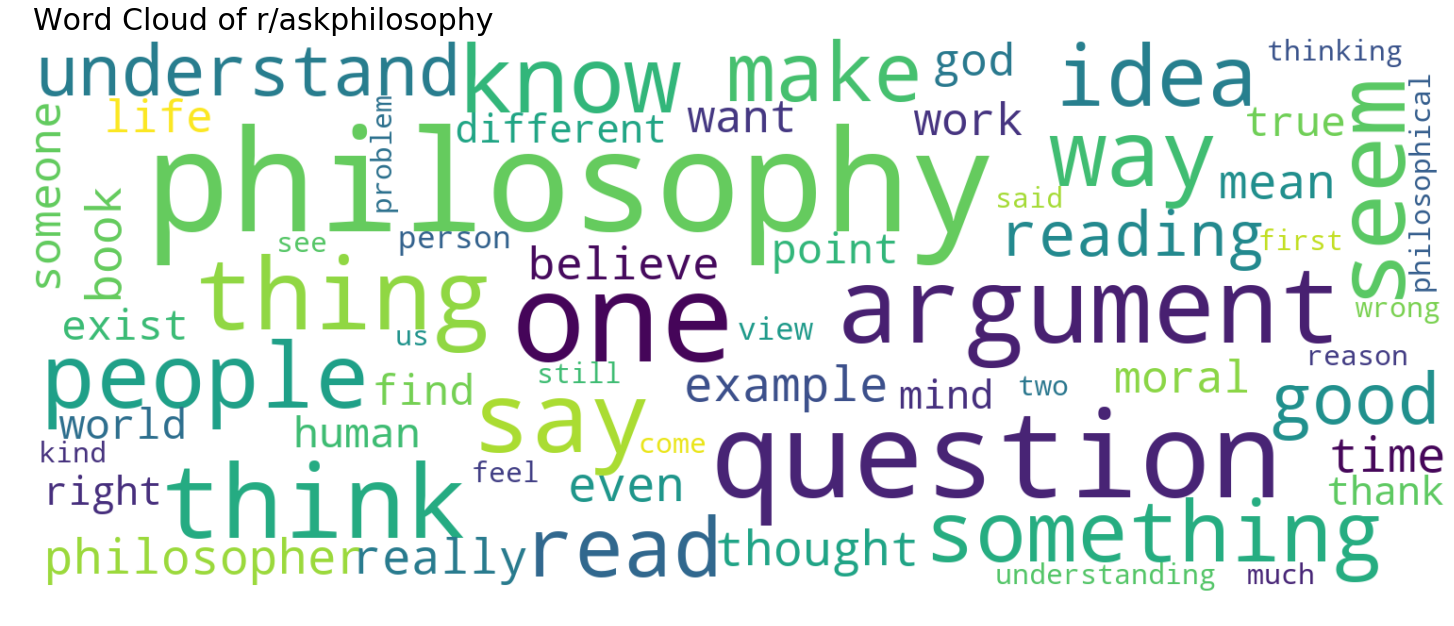

In [17]:
text = " ".join(e for e in phi_wordcloud['selftext_cleaned'])

wordcloud = WordCloud(max_font_size=50,
                      min_font_size = 10,
                      max_words=150, 
                      background_color='white',
                      scale=3,
                      width=500).generate(text);

# Display generated image
plt.figure(figsize = (20, 18), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of r/askphilosophy', loc='left', size = 30)
plt.tight_layout(pad = 0) 
plt.show();

# Save image file 
wordcloud.to_file("./askphilosophy_wordcloud.png")

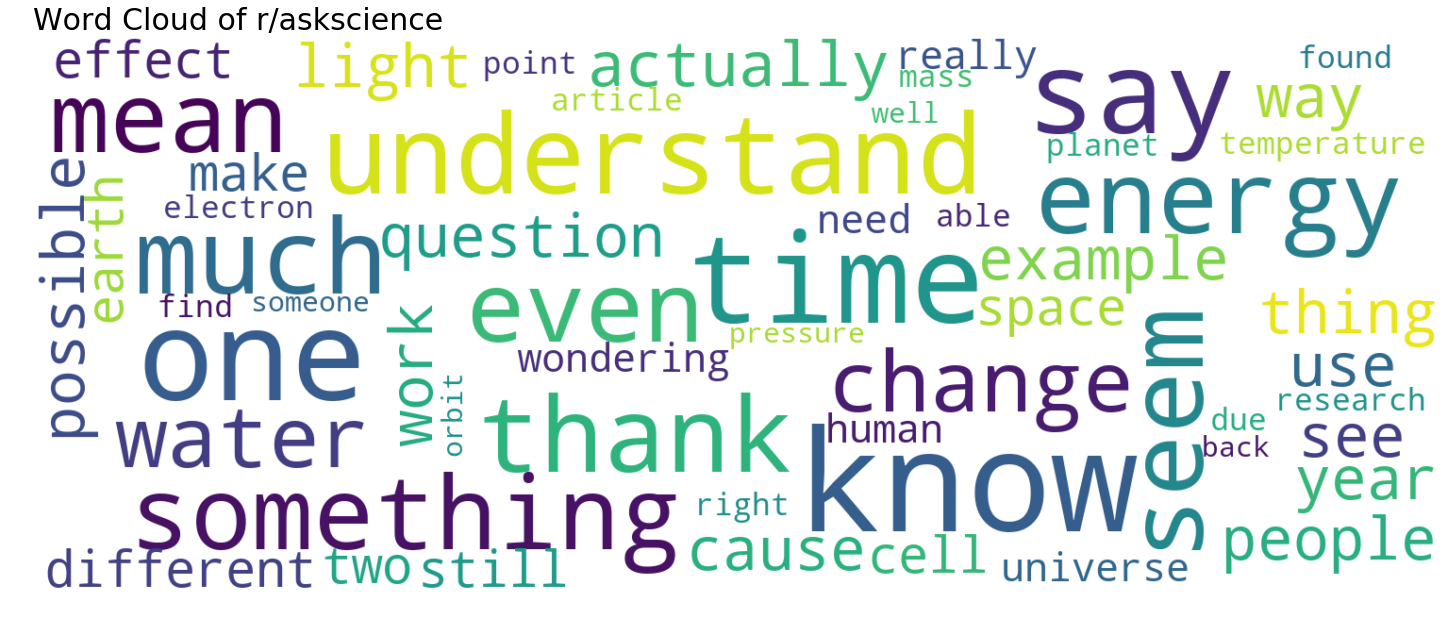

In [18]:
text = " ".join(e for e in sci_wordcloud['selftext_cleaned'])

wordcloud = WordCloud(max_font_size=50,
                      min_font_size = 10,
                      max_words=150, 
                      background_color='white',
                      scale=3,
                      width=500).generate(text);

# Display generated image
plt.figure(figsize = (20, 18), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of r/askscience', loc='left', size = 30)
plt.tight_layout(pad = 0) 
plt.show();

# Save image file 
wordcloud.to_file("./askscience_wordcloud.png")

### Model Prep: Set up `X` and `y`

- `X` will be the `selftext_cleaned` column
- `y` will be the `subreddit` column

In [19]:
X = df['selftext_cleaned']
y = df['askscience']

### Train/Test Split Data

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [49]:
# Generate a baseline accuracy score for comparison later
baseline = y_test.value_counts(normalize=True)
baseline 

0    0.557078
1    0.442922
Name: askscience, dtype: float64

<a id="pipeline"></a> 
# Create Pipelines for Modelling

### i) Pipeline with Naive Bayes  
> - Pipeline: GridSearchCV, CountVectorizer & Naive Bayes
> - Pipeline: GridSearchCV, TF-IDF & Naive Bayes

#####  ia) GridSearchCV, CountVectorizer & Naive Bayes

In [23]:
# Instantiate Pipeline object of two steps
# First, count vectorize the data
# Second, train a naive bayes on the data
pipeline = Pipeline([
    ('cvec',  CountVectorizer()),
    ('mnb', MultinomialNB())   
])

# Create a dictionary of all the parameter options 
pipe_params = {
    'cvec__max_features': [900, 1250, 2000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.7, .9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english'],
    'mnb__alpha': np.linspace(0.5, 1.5, 5),
    'mnb__fit_prior': [True, False]
}

# Conduct parameter optimisation with pipeline
# Create a grid search object
grid_cvec_mnb = GridSearchCV(pipeline, param_grid=pipe_params, cv=3)

# Fit the grid search to training data
grid_cvec_mnb.fit(X_train, y_train)
print(grid_cvec_mnb.best_score_)

0.9207920792079208


In [24]:
grid_cvec_mnb.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'mnb__alpha': 0.5,
 'mnb__fit_prior': False}

#####  ib) GridSearchCV, CountVectorizer & Naive Bayes

In [25]:
# Instantiate Pipeline object of two steps
# First, tf-idf vectorize the data
# Second, train a naive bayes on the data
pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('mnb', MultinomialNB())   
])

# Create a dictionary of all the parameter options 
pipe_params = {
    'tfidf__max_features': [900, 1250, 2000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.5, .75, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': ['english'],
    'mnb__alpha': np.linspace(0.5, 1.5, 5),
    'mnb__fit_prior': [True, False]
}

# Conduct parameter optimisation with pipeline
# Create a grid search object
grid_tfidf_mnb = GridSearchCV(pipeline, param_grid=pipe_params, cv=3)

# Fit the GridSearch to training data
grid_tfidf_mnb.fit(X_train, y_train)
print(grid_tfidf_mnb.best_score_)

0.9246001523229246


In [26]:
grid_tfidf_mnb.best_params_

{'mnb__alpha': 0.5,
 'mnb__fit_prior': False,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

### ii) Pipeline with KNN  
> - Pipeline: GridSearchCV, CountVectorizer & KNN
> - Pipeline: GridSearchCV, TF-IDF & KNN

#####  iia) GridSearchCV, CountVectorizer & KNN

In [27]:
# Instantiate Pipeline object of two steps
# First, couunt vectorize the data
# Second, train a KNeighbors classifier on the data
pipeline = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

#pipe_cvec_knn.get_params().keys()
# Create a dictionary of all the parameter options 
pipe_params = {
    'cvec__max_features': [900, 1250, 2000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.7, .9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english'],
    'knn__n_neighbors': [5, 10, 15, 20],
    'knn__metric': ['minkowski', 'euclidean']  
}

# Conduct parameter optimisation with pipeline
# Create a GridSearch object
grid_cvec_knn = GridSearchCV(pipeline, param_grid=pipe_params, cv=3)

# Fit the GridSearch to training data
grid_cvec_knn.fit(X_train, y_train)
print(grid_cvec_knn.best_score_)

0.667936024371668


In [28]:
grid_cvec_knn.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 900,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'knn__metric': 'minkowski',
 'knn__n_neighbors': 20}

#####  iib) GridSearchCV, TfidfVectorizer & KNN

In [29]:
# Instantiate Pipeline object of two steps
# First, Tfidf-vectorize the data
# Second, train a KNeighbors classifier on the data
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Create a dictionary of all the parameter options 
pipe_params = {
    'tfidf__max_features': [900, 1250, 2000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.5, .75, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': ['english'],
    'knn__n_neighbors': [5, 10, 15, 20],
    'knn__metric': ['minkowski', 'euclidean']  
}

# Conduct parameter optimisation with pipeline
# Create a GridSearch object
grid_tfidf_knn = GridSearchCV(pipeline, param_grid=pipe_params, cv=3)

# Fit the GridSearch to training data
grid_tfidf_knn.fit(X_train, y_train)
print(grid_tfidf_knn.best_score_)

0.8598629093678599


In [30]:
grid_tfidf_knn.best_params_

{'knn__metric': 'minkowski',
 'knn__n_neighbors': 15,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

### iii) Pipeline with Logistic Regression
> - Pipeline: GridSearchCV, CountVectorizer & Logistic Regression
> - Pipeline: GridSearchCV, TF-IDF & Logistic Regression

#####  iiia) GridSearchCV, CountVectorizer & Logistic Regression

In [31]:
# GridSearchCV, CountVectorizer & Logistic Regression
# Instantiate Pipeline object of two steps
# First, count vectorize the data
# Second, train a logistic regression 
pipeline = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())   
])

# Create a dictionary of all the parameter options 
pipe_params = {
    'cvec__max_features': [900, 1250, 2000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.7, .9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': ['english'],
    'lr__C': np.linspace(0.5, 1.5, 5),
    'lr__solver' : ['lbfgs', 'liblinear'],
    'lr__max_iter': [50, 75, 100]  
}

# Conduct parameter optimisation with pipeline
# Create a GridSearch object
grid_cvec_lr = GridSearchCV(pipeline, param_grid=pipe_params, cv=3)

# Fit the GridSearch to training data
grid_cvec_lr.fit(X_train, y_train)
print(grid_cvec_lr.best_score_)

0.8948971820258949


In [32]:
grid_cvec_lr.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'lr__C': 0.5,
 'lr__max_iter': 50,
 'lr__solver': 'lbfgs'}

#####  iiib) GridSearchCV, TfidfVectorizer & Logistic Regression

In [33]:
# Instantiate Pipeline object of two steps
# First, Tfidf-vectorize the data
# Second, train a logistic regression 
pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer()),
    ('lr', LogisticRegression())   
])

# Create a dictionary of all the parameter options 
pipe_params = {
    'tfidf__max_features': [900, 1250, 2000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.5, .75, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__stop_words': ['english'],
    'lr__C': np.linspace(0.5, 1.5, 5),
    'lr__solver' : ['lbfgs', 'liblinear'],
    'lr__max_iter': [50, 75, 100]  
}

# Conduct parameter optimisation with pipeline
# Create a GridSearch object
grid_tfidf_lr = GridSearchCV(pipeline, param_grid=pipe_params, cv=3)

# Fit the GridSearch to training data
grid_tfidf_lr.fit(X_train, y_train)
print(grid_tfidf_lr.best_score_)

0.9093678598629094


In [34]:
grid_tfidf_lr.best_params_

{'lr__C': 1.25,
 'lr__max_iter': 50,
 'lr__solver': 'lbfgs',
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

##### Summary: 

The 2nd model, TF-IDF Vectorizer & Naive Bayes performed best with a score of 0.9246,
with the following parameters: 


```Python
{'mnb__alpha': 0.5,
 'mnb__fit_prior': False,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}
```

Hence, we will be selecting this model for further analysis.

<a id="model_sel"></a> 
# vi) Model Selection & Evaluation
  
  
> ##### Naive Bayes  
> - Pipeline: GridSearchCV, with TF-IDF Vectorizer & Naive Bayes


- Generate Confusion Matrix

In [35]:
# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', max_features=2000, stop_words='english')

# Fit our TfidfVectorizer on the training data and transform training data
X_train_tfidf = pd.DataFrame(tfidf.fit_transform(X_train).todense(), 
                           columns = tfidf.get_feature_names()) 

# Transform our testing data with the already-fit TfidfVectorizer
X_test_tfidf = pd.DataFrame(tfidf.transform(X_test).todense(),
                          columns = tfidf.get_feature_names()) 

In [36]:
# Instantiate Multinomial Naive Bayes
model = MultinomialNB(alpha=.5, fit_prior=False)

# Fit vectorized X_train to model
model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False)

In [37]:
# Score our model on the training set
print('MultinomialNB Accuracy on Train: ', model.score(X_train_tfidf, y_train))

MultinomialNB Accuracy on Train:  0.9756283320639756


In [38]:
# Score our model on the testing set.
print('MultinomialNB Accuracy on Test: ', model.score(X_test_tfidf, y_test))

MultinomialNB Accuracy on Test:  0.9223744292237442


Comparing the training and testing scores we can see that the model is not overly fitted.

##### Generate Confusion Matrix

In [39]:
predictions = model.predict(X_test_tfidf)

In [44]:
# Generate confusion matrix
confusion_matrix(y_test, predictions)

array([[231,  13],
       [ 21, 173]])

In [45]:
tp, fp, fn, tn = confusion_matrix(y_test, predictions).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 173
False Positives: 13
False Negatives: 21
True Positives: 231


In [53]:
# Compare scores to baseline
baseline

0    0.557078
1    0.442922
Name: askscience, dtype: float64

In [69]:
print('0    ', round((231/438), 3)) # True Positives (correctly predicted r/askscience post)  / Total
print('1    ', round((173/438), 3)) # True Negatives (correctly predicted r/askphilosophy post) / Total

0     0.527
1     0.395


In [75]:
# Correctly predicted range of r/askscience and r/askphilosophy post
(173/438) / 0.442922, (231/438) / .55

(0.8917533311729192, 0.958904109589041)

<a id='conclusions'></a> 
# vii) Conclusions

- **Insights**:
    - Comparing the 3 different classification models: `MultinomialNB`, `Logistic Regression`, and `KNearestNeighbours` we can see that `MultinomialNB` produces the highest accuracy scores consistently acorss both vectorisation methods.

    - The selected model, which Tf-Idf vectorised and then classified using `MultinomialNB` was what gave us the best accuracy scores of 0.97 and 0.92 on the training and test datasets respectively.
        - Achieving a score of 0.92 would mean that we would be able to differentatiate between a *r/askscience* between a *r/askphilosophy* thread 9 out of 10 times correctly.
        - A true positive meant that the model correctly predicted a *r/askscience* post, while a true negative meant that the model correctly predicted a *r/askhilosophy* reddit post. 
            - This rate compared to the baseline accuracy was within a 89% - 95% range
           
- **Limitations**:
    - The model chosen `MultinomialNB`,  is only effective when used on smaller sample sizes, anything above 100k and we would like have chosen another model.
    - The `MultinomialNB` model makes a very strong assumption on the shape of your data distribution, i.e. any two features are independent given the output class. Hence, the result could have been potentially bad.
        